# 이미지 데이터셋 수집 - 일본 사진

출처: https://ko.photo-ac.com/search/%EC%A0%90%EC%9E%90%20%EB%B8%94%EB%A1%9D?per_page=180&page=1&orderBy=recent_popular&color=all&modelCount=-2&shape=all&is_tag=true

In [2]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import zipfile
from google.colab import files
import re

In [ ]:
# 이미지 다운로드 함수
def download_image(url, folder):
    try:
        # 이미지를 요청하고 응답을 받는다
        response = requests.get(url)
        if response.status_code == 200:
            # 이미지 파일 이름을 추출
            image_name = url.split("/")[-1]
            # 저장할 경로 설정
            image_path = os.path.join(folder, image_name)
            # 이미지 파일을 저장한다
            with open(image_path, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded: {image_name}")
    except Exception as e:
        print(f"Failed to download {url}. Error: {e}")

In [ ]:
# 웹사이트에서 모든 이미지 URL을 추출하는 함수
def fetch_images_from_url(url, folder):
    # 폴더가 존재하지 않으면 생성
    if not os.path.exists(folder):
        os.makedirs(folder)

    try:
        # 웹사이트 요청
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # 모든 <img> 태그를 찾는다
        img_tags = soup.find_all('img')

        # 각 이미지의 src 속성을 가져와서 다운로드
        for img_tag in img_tags:
            img_url = img_tag.get('src')
            if img_url:
                # 절대 URL로 변환 (상대 URL일 경우)
                img_url = urljoin(url, img_url)
                # 이미지 다운로드
                download_image(img_url, folder)
    except Exception as e:
        print(f"Failed to fetch images from {url}. Error: {e}")

In [ ]:
# 웹사이트 URL과 저장 폴더 설정
website_urls = {}

# 1 ~ 23 페이지
for i in range (1, 24):
  website_urls[f"website_url_{i}"] = f"https://ko.photo-ac.com/search/%EC%A0%90%EC%9E%90%20%EB%B8%94%EB%A1%9D?per_page=180&page={i}&orderBy=recent_popular&color=all&modelCount=-2&shape=all&is_tag=true"

folder_name = "downloaded_images"

# 이미지 다운로드 시작
for url in website_urls.values():
    fetch_images_from_url(url, folder_name)

In [ ]:
# 다운로드할 폴더 경로
folder_path = '/content/downloaded_images'  # 다운로드하려는 폴더 경로

# 압축 파일 이름 (ZIP 파일)
zip_file_path = '/content/images_folder.zip'

# 폴더를 ZIP 파일로 압축
def zip_folder(folder_path, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # 폴더 내의 모든 파일을 압축
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                # ZIP 파일 내에서 폴더 구조 유지
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# 폴더를 압축
zip_folder(folder_path, zip_file_path)

# 압축된 ZIP 파일을 로컬로 다운로드
files.download(zip_file_path)

# Microsoft Bing 에서 이미지 수집 - 한국 사진

In [ ]:
# bing에서 이미지를 원본으로 다운로드하는 라이브러리
!pip install bing-image-downloader

In [ ]:
from bing_image_downloader import downloader
downloader.download('점자블록', limit=200,  output_dir='dataset', adult_filter_off=True, force_replace=False, timeout=60, verbose=True)

In [ ]:
import shutil

# 'dataset' 폴더를 zip 파일로 압축
shutil.make_archive('/content/dataset', 'zip', '/content/dataset')

# 점자 블록 유/무 이미지 분류

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
zip_file_path_1 = '/content/drive/MyDrive/Block/project.zip'
zip_file_path_2 = '/content/drive/MyDrive/Block/----  Object Detection.v4i.yolov11.zip'

In [8]:
import zipfile

# zip 파일을 열고 압축을 풀기
with zipfile.ZipFile(zip_file_path_1, 'r') as zip_ref:
    zip_ref.extractall('/content/images')

with zipfile.ZipFile(zip_file_path_2, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from PIL import Image
from torchvision import models
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 모델 입력 크기 맞추기
    transforms.Grayscale(num_output_channels=3),  # 흑백으로 변환 (1채널로)
    transforms.ToTensor(),          # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet의 평균과 표준편차로 정규화
])

In [ ]:
train_dir = '/content/images/train dataset'

In [ ]:
# ImageFolder로 데이터 로드
train_data = datasets.ImageFolder(root=train_dir, transform=transform)

In [ ]:
# 훈련 데이터와 검증 데이터를 9:1로 분리
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

In [ ]:
# DataLoader 준비
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# 사전 훈련된 ResNet18 모델 로드
model = models.resnet18(pretrained=True)

# 마지막 레이어를 2개의 클래스를 분류하도록 수정
model.fc = nn.Linear(model.fc.in_features, 2)  # 2개의 클래스: 'yes_block'과 'no_block'

# 모델을 GPU로 이동 (가능한 경우)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()  # 손실 함수
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam 옵티마이저

In [ ]:
# 학습률 스케줄러 설정
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# 얼리 스탑을 위한 변수 설정
early_stopping_patience = 5  # 성능 향상이 없을 때 훈련을 중단할 에포크 수
best_val_acc = 0.0
epochs_without_improvement = 0  # 성능 향상이 없었던 에포크 수

# 모델 훈련
num_epochs = 20
best_model_wts = model.state_dict()

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # 훈련 단계
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    # 손실 및 정확도 출력
    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    val_loss = val_loss / val_size
    val_acc = val_corrects.double() / val_size

    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # 모델 저장 (가장 높은 정확도를 기록)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        epochs_without_improvement = 0  # 성능 향상 시 카운트 리셋
    else:
        epochs_without_improvement += 1

    # 얼리 스탑: 성능 향상이 없으면 훈련을 중단
    if epochs_without_improvement >= early_stopping_patience:
        print("Early stopping: No improvement in validation accuracy for 5 epochs.")
        break

    # 학습률 스케줄러 적용
    scheduler.step()


print('Training complete')
model.load_state_dict(best_model_wts)


Epoch 1/20
----------
Training Loss: 0.5020 Acc: 0.7456
Validation Loss: 0.4279 Acc: 0.8684
Epoch 2/20
----------
Training Loss: 0.0874 Acc: 0.9882
Validation Loss: 0.4814 Acc: 0.8947
Epoch 3/20
----------
Training Loss: 0.0342 Acc: 0.9970
Validation Loss: 0.3035 Acc: 0.9474
Epoch 4/20
----------
Training Loss: 0.0104 Acc: 1.0000
Validation Loss: 0.2795 Acc: 0.9211
Epoch 5/20
----------
Training Loss: 0.0072 Acc: 1.0000
Validation Loss: 0.2216 Acc: 0.9211
Epoch 6/20
----------
Training Loss: 0.0050 Acc: 1.0000
Validation Loss: 0.2271 Acc: 0.9211
Epoch 7/20
----------
Training Loss: 0.0031 Acc: 1.0000
Validation Loss: 0.2355 Acc: 0.9211
Epoch 8/20
----------
Training Loss: 0.0028 Acc: 1.0000
Validation Loss: 0.2183 Acc: 0.9211
Early stopping: No improvement in validation accuracy for 5 epochs.
Training complete


<All keys matched successfully>

In [ ]:
# 최종 모델 저장
torch.save(model.state_dict(), 'best_model.pth')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 모델 로드 (최고의 모델)
model_path = 'best_model.pth'
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2개의 클래스 (yes_block, no_block)
model.load_state_dict(torch.load(model_path))
model.to(device)  # 모델을 디바이스(GPU 또는 CPU)로 이동
model.eval()  # 평가 모드

In [ ]:
images_folder = '/content/images/images_folder'
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

In [ ]:
# 예측 함수
def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # 배치 차원 추가
    image = image.to(device)

    # 예측
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()  # 예측된 클래스 반환

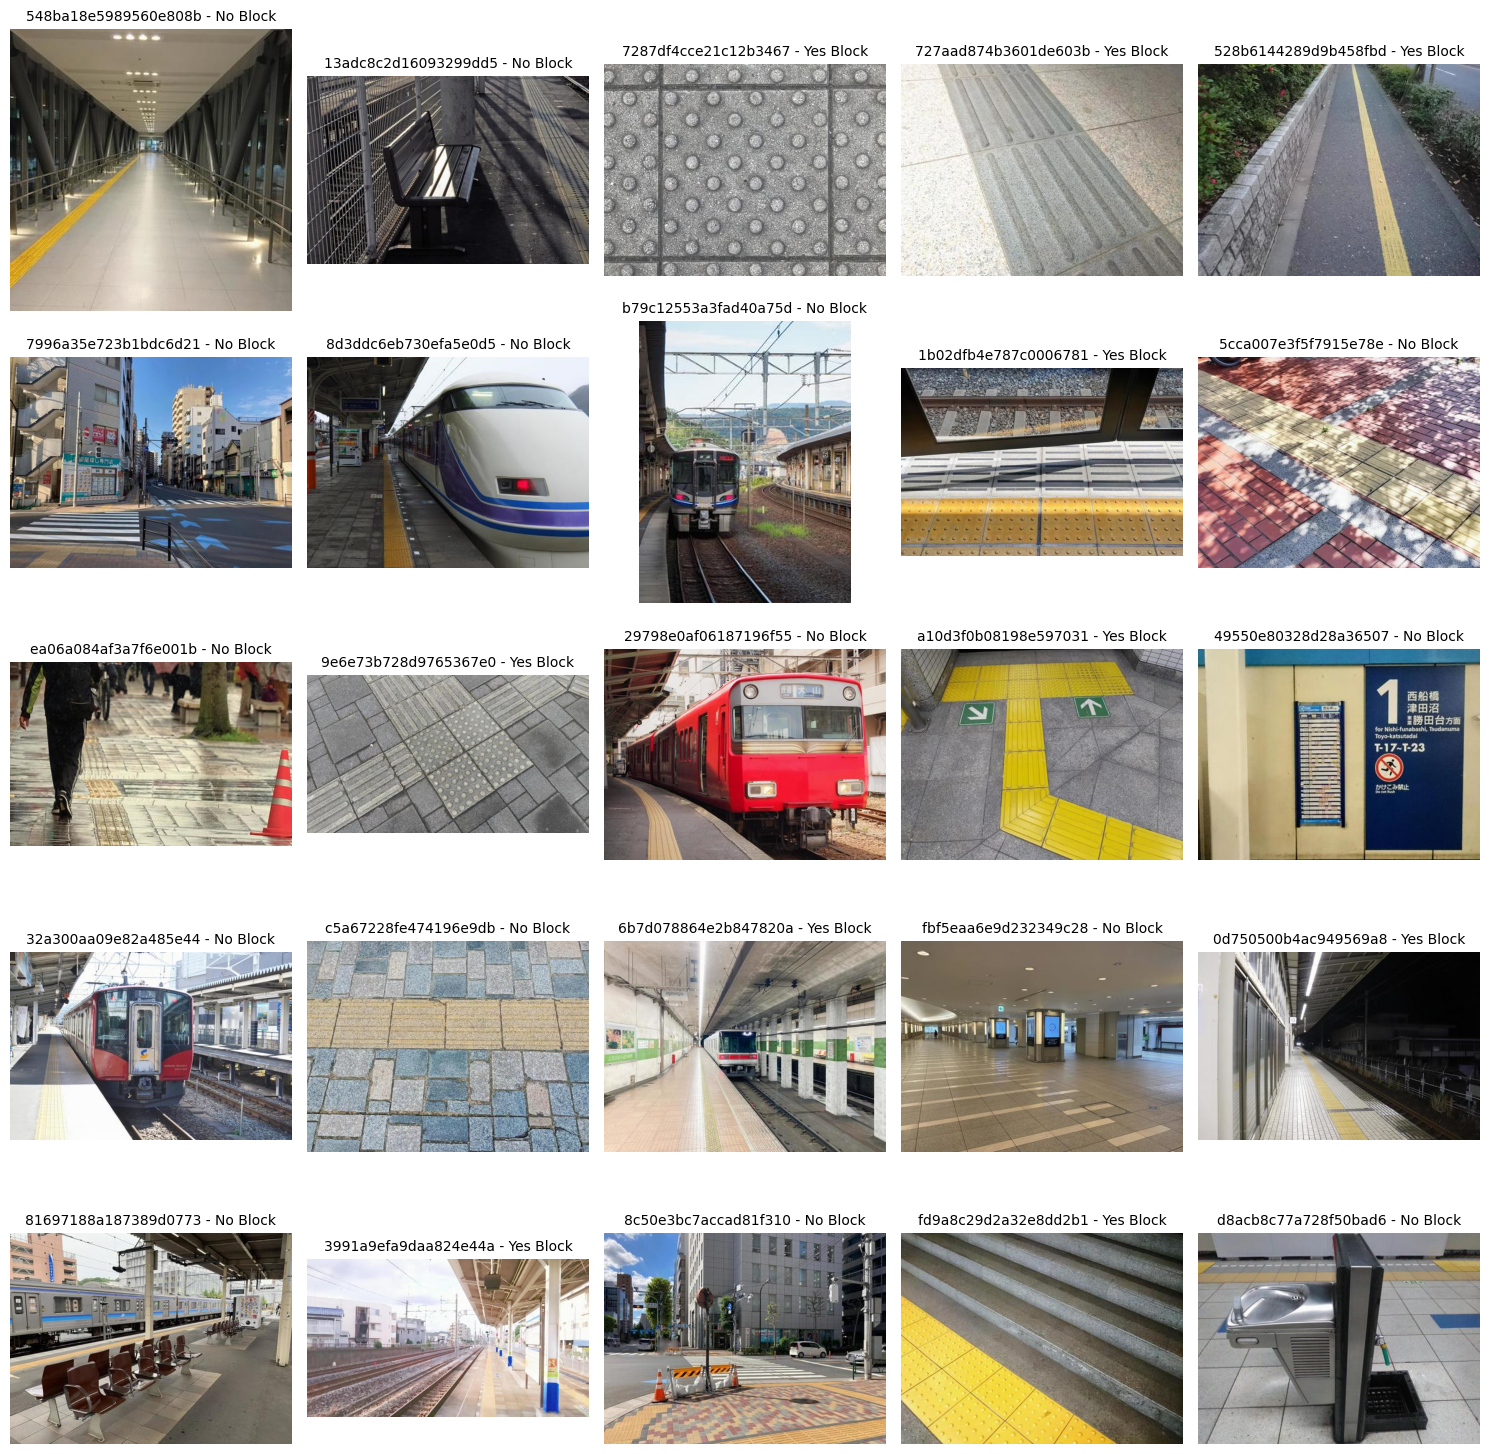

In [ ]:
# 예측 및 시각화
fig, axes = plt.subplots(5, 5, figsize=(15, 15))  # 5x5 그리드 (25개 이미지)
axes = axes.flatten()

for i, image_file in enumerate(image_files[:25]):  # 최대 25개의 이미지를 시각화
    image_path = os.path.join(images_folder, image_file)
    prediction = predict_image(image_path)

    # 이미지를 로드하고 시각화
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

    # 파일 이름을 자르고, 예측된 클래스를 제목으로 추가
    short_name = image_file[:20]  # 파일 이름 길이를 20자로 자르기
    if prediction == 0:
        title = f'{short_name} - No Block'
    else:
        title = f'{short_name} - Yes Block'

    # 제목을 작게 설정하여 겹치지 않도록 함
    axes[i].set_title(title, fontsize=10)

plt.tight_layout()
plt.show()

# 객채 인식 - YOLOv11

In [ ]:
# YOLO 라이브러리 다운로드
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11m.pt")

# Train the model
train_results = model.train(
    data="/content/dataset/data.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
    imgsz=640,  # training image size
    device=0,  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

In [ ]:
# 검증 데이터로 모델 성능 테스트
metrics = model.val()

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs


val: Scanning /content/dataset/valid/labels.cache... 90 images, 2 backgrounds, 0 corrupt: 100%|██████████| 90/90 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


                   all         90        159      0.951      0.685      0.837      0.644
            Go_Forward         50         79      0.981      0.638      0.835      0.618
                  Stop         67         80      0.921      0.732      0.839       0.67
Speed: 0.4ms preprocess, 25.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
# 이미지에 모델 적용해보기
results = model("/content/dataset/test/images")

for result in results:
    result.show()

In [ ]:
# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model

# 동영상에서 점자블록 인식

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
model = YOLO("/content/sample_data/test/best.onnx")

# Run inference on 'bus.jpg' with arguments
model.predict("/content/sample_data/test/KakaoTalk_20241211_154344135.mp4", save=True, imgsz=640, conf=0.5)

# 동영상 알림

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
model = YOLO("/content/dataset/best.onnx")

# Define path to video file
source = "/content/drive/MyDrive/Block/KakaoTalk_20241211_154344135.mp4"

# Run inference on the source
results = model(source, stream=True)  # generator of Results objects

In [ ]:
import cv2
from ultralytics import YOLO

# 모델 로딩 (ONNX 모델)
model = YOLO("/content/sample_data/test/best.onnx")

# 동영상 파일 경로
source = "/content/drive/MyDrive/Block/KakaoTalk_20241211_154344135.mp4"
output_path = "/content/drive/MyDrive/Block/output_video.mp4"

# VideoCapture로 동영상 파일 열기
cap = cv2.VideoCapture(source)

# 동영상의 프레임 속도, 크기 등 가져오기
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# VideoWriter 객체 생성 (수정된 동영상 저장용)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# YOLO 결과를 generator로 받아 처리
for frame in model(source, stream=True):  # `results` 대신 직접 `frame`을 처리
    # 프레임 정보 얻기
    img = frame.orig_img  # 원본 이미지

    # 결과에서 객체 바운딩 박스 및 클래스 이름 얻기
    boxes = frame.boxes  # 바운딩 박스들
    names = frame.names  # 클래스 이름 딕셔너리

    # 'Stop' 클래스를 찾아서 해당 바운딩 박스 처리
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()  # 바운딩 박스 좌표
        cls = int(box.cls[0])  # 클래스 인덱스
        class_name = names[cls]  # 클래스 이름

        if class_name == 'Stop':
            # 'Stop' 바운딩 박스의 중앙 계산
            stop_center = ((x1 + x2) // 2, (y1 + y2) // 2)

            # 중앙이 이미지 하단에 가까운지 확인
            if stop_center[1] > frame_height * 0.8:  # 이미지 하단 20% 이하에 닿는지 확인
                # 텍스트 출력 위치 (오른쪽 아래)
                text = "Stop"
                position = (frame_width - 150, frame_height - 50)  # 이미지 오른쪽 아래에 출력

                # OpenCV로 텍스트 추가
                cv2.putText(img, text, position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # 수정된 프레임을 VideoWriter에 저장
    out.write(img)

# 동영상 처리 종료
cap.release()
out.release()
cv2.destroyAllWindows()
